In [51]:
import pandas as pd
import numpy as np

from utils import *

import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import ParameterGrid

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller

import pmdarima as pm
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)   
warnings.filterwarnings("ignore") # specify to ignore warning messages

In [8]:
!ls -lh data

total 1,8M
-rw-r--r-- 1 ZukiPC 197609 1,7M ago 12 14:41 data.csv
-rw-r--r-- 1 ZukiPC 197609  13K ago 12 14:41 sample_submission.csv


In [9]:
data = pd.read_csv('data/data.csv')

In [10]:
data.head()

,date,variable,value
0,2004-01-01 00:00:00,area_1,16.853
1,2004-01-01 01:00:00,area_1,16.450
2,2004-01-01 02:00:00,area_1,16.517
3,2004-01-01 03:00:00,area_1,16.873
4,2004-01-01 04:00:00,area_1,17.064


# EDA

In [11]:
data['date'] = pd.to_datetime(data.date, infer_datetime_format=True)
data = data.set_index(['date'])
data = data.sort_index()

In [12]:
data.tail(10)

,variable,value
date,,
2005-12-15 20:00:00,area_1,NaN
2005-12-15 21:00:00,area_2,NaN
2005-12-15 21:00:00,area_3,115.604
2005-12-15 21:00:00,area_1,NaN
2005-12-15 22:00:00,area_3,104.989
2005-12-15 22:00:00,area_1,NaN
2005-12-15 22:00:00,area_2,NaN
2005-12-15 23:00:00,area_2,NaN
2005-12-15 23:00:00,area_1,NaN


In [13]:
analysis_dict = {'variables': list(data.columns.values),
                 'count': list(data.count().values),
                 'v_types': list(data.dtypes.values),
                 'n_null': list(data.isnull().sum().values),
                 'n_uniques': list(data.nunique().values)}
analysis = pd.DataFrame(analysis_dict)
analysis

,variables,count,v_types,n_null,n_uniques
0,variable,51480,object,0,3
1,value,43656,float64,7824,37275


area_1 missing values: 5136


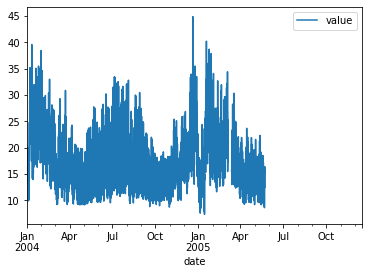

area_2 missing values: 2184


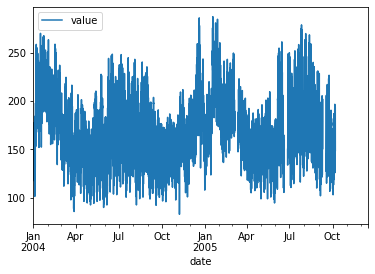

area_3 missing values: 504


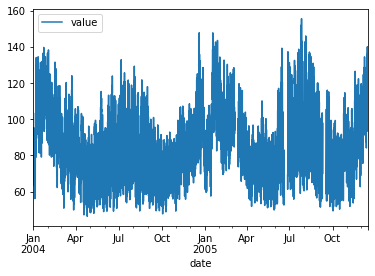

In [14]:
for area in data['variable'].unique():
    print(area + ' missing values: ' + str(data[data.variable==area].value.isnull().sum()))
    data[data.variable==area].drop(columns=['variable']).plot()
    plt.show()

In [15]:
df1 = data[data.variable=='area_1'].drop(columns=['variable']).resample('D').mean()
df2 = data[data.variable=='area_2'].drop(columns=['variable']).resample('D').mean()
df3 = data[data.variable=='area_3'].drop(columns=['variable']).resample('D').mean()

In [16]:
aux = df3[df3.isnull()['value']]
aux.loc['Sep 2005']

,value
date,
2005-09-10,NaN
2005-09-11,NaN
2005-09-12,NaN
2005-09-13,NaN
2005-09-14,NaN
2005-09-15,NaN
2005-09-16,NaN


###### Missing data: 
    DF1:
        6-12 Mar 2005
        23 Mai on
    DF2:
        06-12 Mar 2005
        20-26 Jun 2005
        10-16 Sep 2005
        07 Oct on
    DF3:
        06-12 Mar 2005
        20-26 Jun 2005
        10-16 Sep 2005   

In [17]:
pause1 = slice('2005-03-06','2005-03-12')
pause2 = slice('2005-06-20','2005-06-26')
pause3 = slice('2005-09-10','2005-09-16')

In [18]:
imputer = KNNImputer() 

df1 = data[data.variable=='area_1'].drop(columns=['variable']).resample('60min').mean()
df1 = df1.loc[df1.index < '2005-05-23']  # (12192, 1)

data1_imputed = imputer.fit_transform(df1)
final_df1 = pd.DataFrame(data1_imputed, index=df1.index, columns=df1.columns)

df2 = data[data.variable=='area_2'].drop(columns=['variable']).resample('60min').mean()
df2 = df2.loc[df2.index < '2005-10-07']  # (15480, 1)

data2_imputed = imputer.fit_transform(df2)
final_df2 = pd.DataFrame(data2_imputed, index=df2.index, columns=df2.columns)

df3 = data[data.variable=='area_3'].drop(columns=['variable']).resample('60min').mean()  # (17160, 1)

data3_imputed = imputer.fit_transform(df3)
final_df3 = pd.DataFrame(data3_imputed, index=df3.index, columns=df3.columns)

###### Decomposing the Series

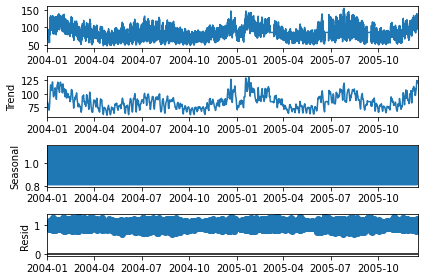

In [19]:
decomposition = seasonal_decompose(final_df3, model='multiplicative')
decomposition.plot()
plt.show()

###### Studying Autocorrelation - ACF-

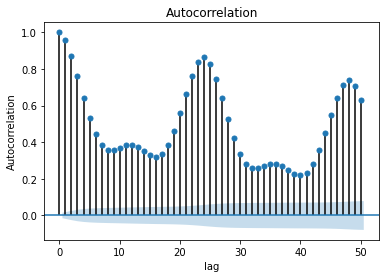

In [20]:
plot_acf(final_df3, alpha=.05, lags=50)
plt.xlabel('lag')
plt.ylabel('Autocorrelation')
plt.show()

###### Studying Partial Auto Correlation - PACF-

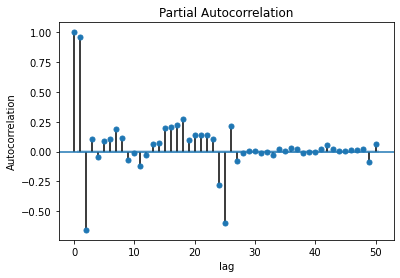

In [21]:
plot_pacf(final_df3, alpha=0.05, lags=50, method='ols')
plt.xlabel('lag')
plt.ylabel('Autocorrelation')
plt.show()

###### Evaluating Stationatiry

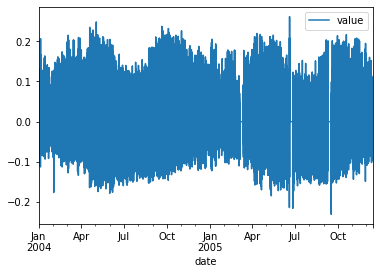

In [22]:
final_df3_st = np.log(final_df3).diff()  # Stabilizing variance and removing trend
final_df3_st.plot()

In [23]:
adfstat, pvalue, usedlag, nobs, critvalues, icbest = adfuller(final_df3_st.dropna())
print('Statistic: %0.02f' % adfstat)
print('pvalue:    %0.03f' % pvalue)

Statistic: -23.01
pvalue:    0.000


# Modeling

## Autoarima

In [24]:
train = final_df1.dropna()[:-168]
test = final_df1.dropna()[-168:]

In [ ]:
sarimax_pipeline = Pipeline([
    ('boxcox', BoxCoxEndogTransformer(lmbda2=1e-6)),
    ('arima', pm.AutoARIMA(trace=True,
                           suppress_warnings=True,
                           m=24,
                           method='nm',
                           maxiter=20))])

sarimax_pipeline.fit(train)
sarimax_forecast = sarimax.predict(168)

In [ ]:
mean_absolute_error(np.exp(sarimax_forecast),np.exp(test))

## Machine Learning

### Linear Regression

In [52]:
predictions = predict_n_periods(series_=final_df1, 
                  n_periods=len(test), 
                  model=LinearRegression(), 
                  num_periods_lagged=30
                  )

In [53]:
mean_absolute_error(test,predictions)

1.6991356504638189

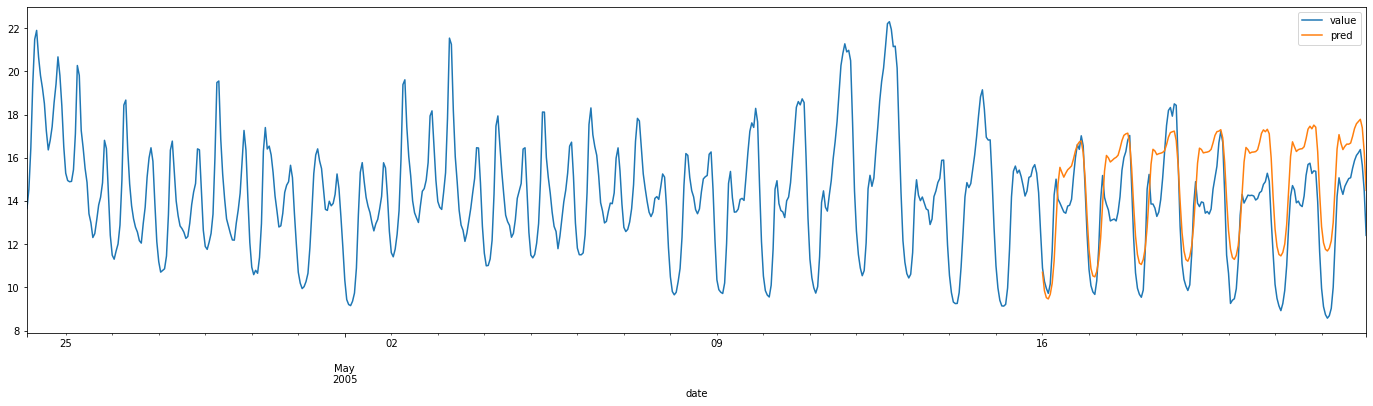

In [54]:
final_df1[11500:].plot(label="original data", figsize=(24, 6))
pd.Series(predictions, index=test.index).plot(label="pred")
plt.legend();

### Parameter Gid

In [57]:
train = final_df1.dropna()[:-256]
val = final_df1[-256:-128]
test = final_df1.dropna()[-168:]

In [ ]:
param_grid = {'model': [LinearRegression(), GradientBoostingRegressor(n_estimators=20, random_state=10)], 
              'num_periods_lagged':np.arange(1,3),
              'num_periods_diffed':np.arange(0,3),
              'rolling' : [[np.mean,np.min,np.max,np.std]]
             }

grid = ParameterGrid(param_grid)

error_lst = []

for params in grid:
    predictions = predict_n_periods(series_= train, 
                      n_periods=128, 
                      model=params['model'], 
                      num_periods_lagged=params['num_periods_lagged'],
                      num_periods_diffed=params['num_periods_diffed'],
                      rolling = params['rolling']
                    )
    
    error_lst.append(mean_absolute_error(val,predictions))
    
best_params = grid[pd.Series(error_lst).idxmin()]